# Module 03: Transformer Block - Interactive Exploration

This notebook provides hands-on exploration of the transformer block, the core building block of transformer models.

**Learning Objectives:**
- Understand how feed-forward networks transform sequences
- Explore layer normalization and residual connections
- Compare Pre-LN vs Post-LN architectures
- Visualize gradient flow through deep stacks
- Analyze attention patterns through multiple blocks

**Prerequisites:**
- Completed Module 01 (Attention)
- Completed Module 02 (Multi-Head Attention)

In [1]:
# Setup
import sys
sys.path.append('../../../')  # Add repo root to path

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from tiny_transformer.feedforward import FeedForward
from tiny_transformer.transformer_block import TransformerBlock
from tiny_transformer.multi_head import MultiHeadAttention

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")

Imports successful!
PyTorch version: 2.9.1


## Part 1: Feed-Forward Networks

The feed-forward network (FFN) is applied to each position independently. It expands the representation to a higher dimension (`d_ff`), applies an activation, and projects back.

**Architecture:** `d_model → d_ff → d_model`

In [2]:
# Create a feed-forward network
d_model = 256
d_ff = 1024  # Typically 4× d_model

ff = FeedForward(d_model=d_model, d_ff=d_ff, dropout=0.0)

# Test input
batch_size, seq_len = 8, 32
x = torch.randn(batch_size, seq_len, d_model)

# Forward pass
output = ff(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\nShape preserved: {x.shape == output.shape}")
print(f"\nParameter count: {sum(p.numel() for p in ff.parameters()):,}")

Input shape:  torch.Size([8, 32, 256])
Output shape: torch.Size([8, 32, 256])

Shape preserved: True

Parameter count: 525,568


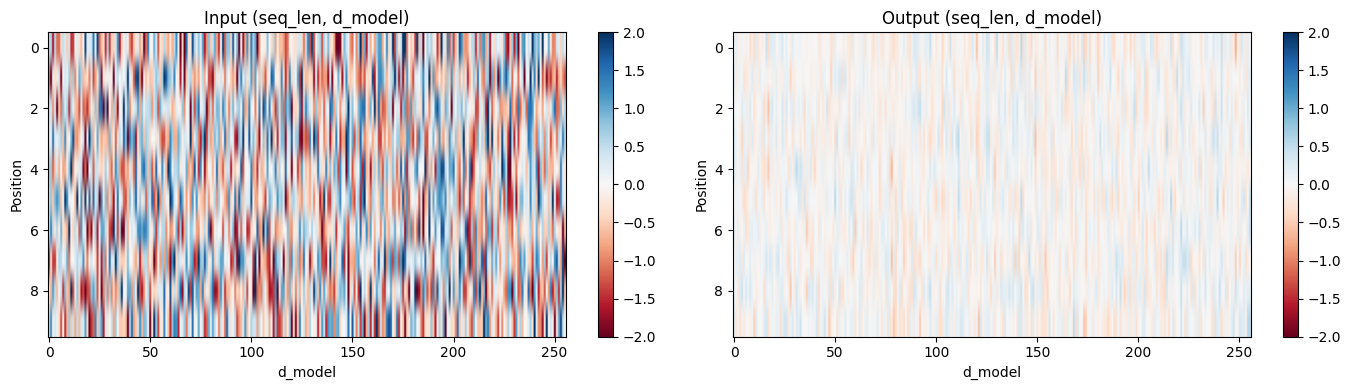

Feed-forward network transforms each position independently!


In [3]:
# Visualize FFN transformation
ff.eval()
x_single = torch.randn(1, 10, d_model)
y_single = ff(x_single)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Input
im0 = axes[0].imshow(x_single[0].detach().numpy(), aspect='auto', cmap='RdBu', vmin=-2, vmax=2)
axes[0].set_title('Input (seq_len, d_model)')
axes[0].set_xlabel('d_model')
axes[0].set_ylabel('Position')
plt.colorbar(im0, ax=axes[0])

# Output
im1 = axes[1].imshow(y_single[0].detach().numpy(), aspect='auto', cmap='RdBu', vmin=-2, vmax=2)
axes[1].set_title('Output (seq_len, d_model)')
axes[1].set_xlabel('d_model')
axes[1].set_ylabel('Position')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

print("Feed-forward network transforms each position independently!")

## Part 2: Complete Transformer Block

The transformer block combines:
1. **Multi-head self-attention** - Allows positions to communicate
2. **Feed-forward network** - Non-linear transformations
3. **Layer normalization** - Stabilizes training
4. **Residual connections** - Enables deep networks

We use **Pre-LN** architecture (modern standard): normalize *before* each sublayer.

In [4]:
# Create a transformer block
d_model = 256
n_heads = 8
d_ff = 1024

block = TransformerBlock(
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    dropout=0.0
)

# Test forward pass
x = torch.randn(8, 32, d_model)
output, attn_weights = block(x, return_attention=True)

print(f"Input shape:            {x.shape}")
print(f"Output shape:           {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"\nTotal parameters:       {sum(p.numel() for p in block.parameters()):,}")

Input shape:            torch.Size([8, 32, 256])
Output shape:           torch.Size([8, 32, 256])
Attention weights shape: torch.Size([8, 8, 32, 32])

Total parameters:       789,760


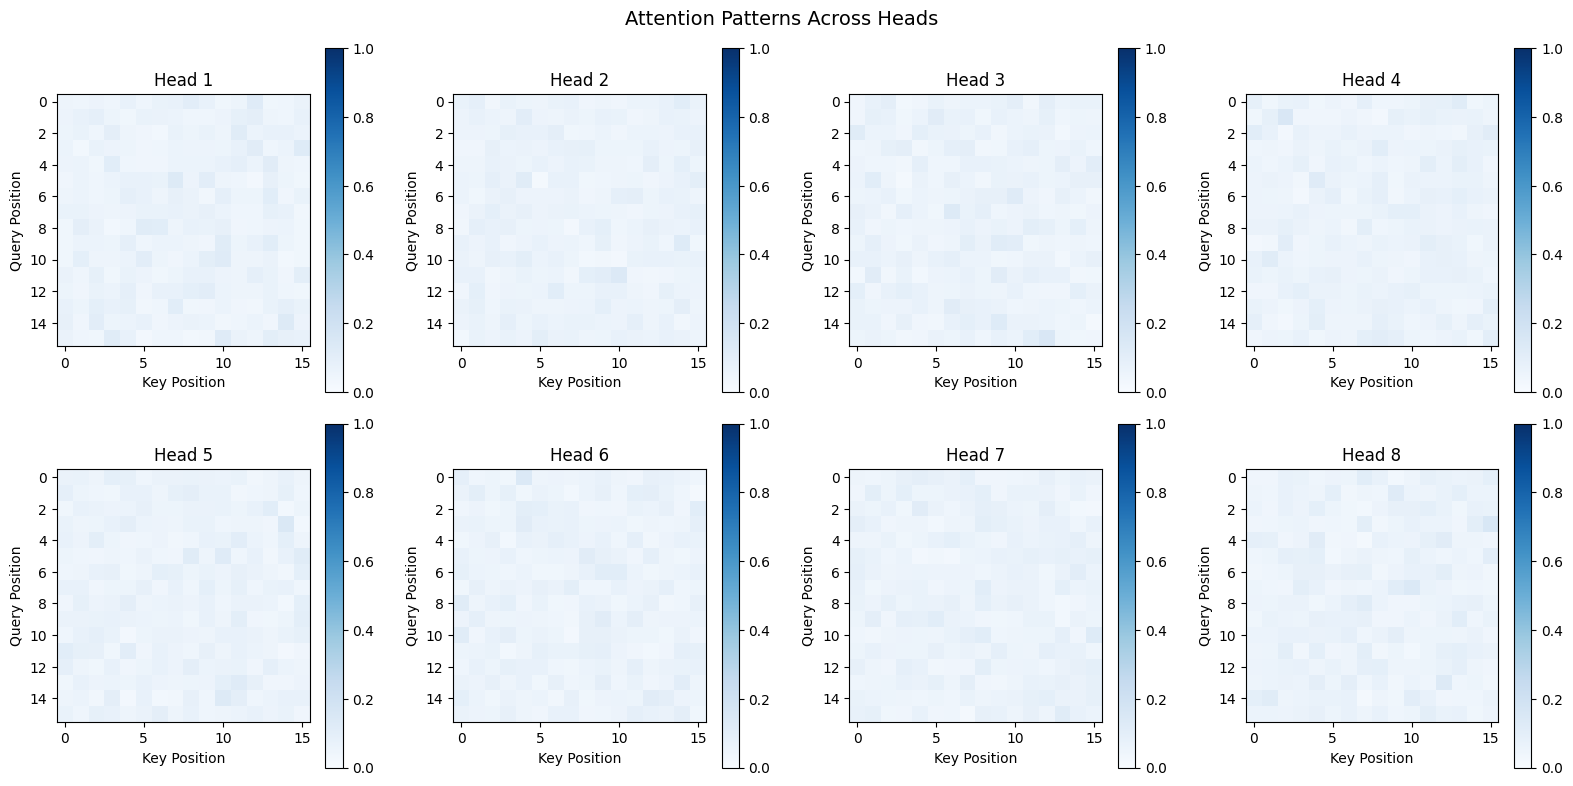

In [5]:
# Visualize attention patterns through block
block.eval()
x_vis = torch.randn(1, 16, d_model)
output_vis, attn_vis = block(x_vis, return_attention=True)

# Plot attention for first few heads
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for head_idx in range(min(8, n_heads)):
    ax = axes[head_idx]
    attn_head = attn_vis[0, head_idx].detach().numpy()
    
    im = ax.imshow(attn_head, cmap='Blues', vmin=0, vmax=1)
    ax.set_title(f'Head {head_idx + 1}')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    plt.colorbar(im, ax=ax)

plt.suptitle('Attention Patterns Across Heads', fontsize=14)
plt.tight_layout()
plt.show()

## Part 3: Residual Connections and Gradient Flow

Residual connections are critical for training deep networks. They create a "gradient highway" that allows gradients to flow directly from output to input.

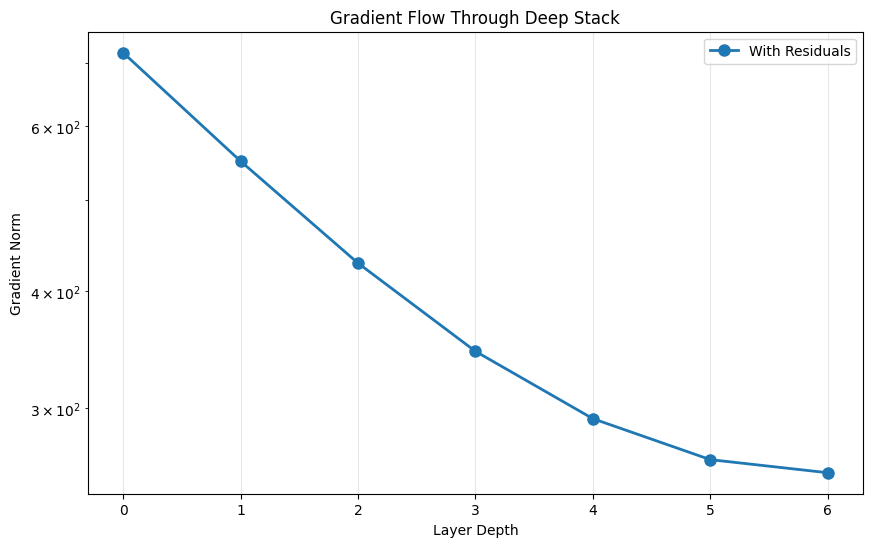

Residual connections maintain gradient flow even in deep networks!


In [6]:
# Compare gradient flow: with vs without residuals
def measure_gradient_flow(model, depth=6):
    """Measure gradient norms at each layer."""
    x = torch.randn(8, 32, d_model, requires_grad=True)
    
    # Forward through stack
    activations = [x]
    for i in range(depth):
        x, _ = model(x)
        # Retain gradients for intermediate (non-leaf) tensors
        x.retain_grad()
        activations.append(x)
    
    # Backward pass
    loss = x.sum()
    loss.backward()
    
    # Measure gradients
    grad_norms = []
    for act in activations:
        if act.grad is not None:
            grad_norms.append(act.grad.norm().item())
        else:
            # If no gradient, append 0 (shouldn't happen with retain_grad)
            grad_norms.append(0.0)
    
    return grad_norms

# Test with transformer block (has residuals)
block_with_residuals = TransformerBlock(d_model=256, n_heads=8, d_ff=1024, dropout=0.0)
grads_with = measure_gradient_flow(block_with_residuals, depth=6)

# Plot gradient flow
plt.figure(figsize=(10, 6))
plt.plot(grads_with, marker='o', linewidth=2, markersize=8, label='With Residuals')
plt.xlabel('Layer Depth')
plt.ylabel('Gradient Norm')
plt.title('Gradient Flow Through Deep Stack')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("Residual connections maintain gradient flow even in deep networks!")

## Part 4: Pre-LN vs Post-LN Architecture

**Pre-LN (Modern):** Normalize *before* sublayers  
**Post-LN (Original):** Normalize *after* sublayers

Pre-LN provides better training stability for deep networks.

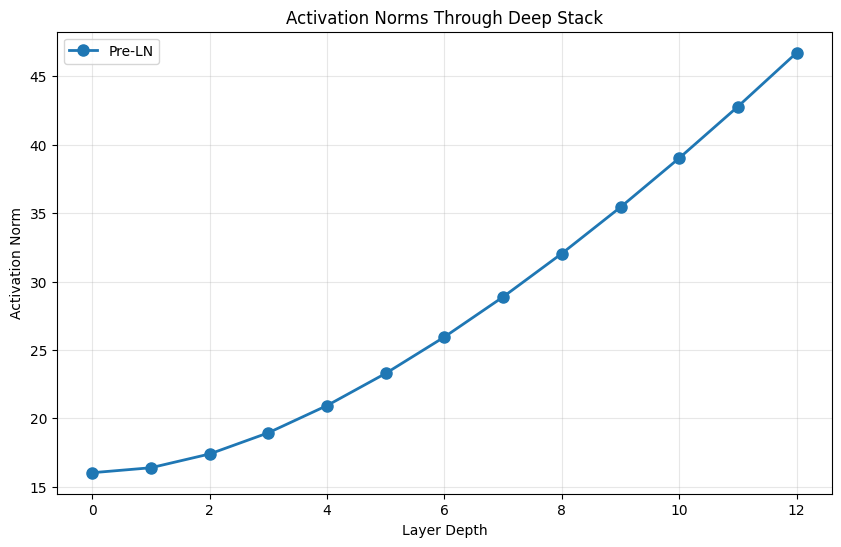

Pre-LN maintains stable norms: 16.03 → 46.72


In [7]:
# Visualize activation norms through deep stack
def measure_activation_norms(block, depth=12):
    """Measure activation norms at each layer."""
    block.eval()
    x = torch.randn(16, 64, d_model)
    
    norms = [x.norm(dim=-1).mean().item()]
    
    for i in range(depth):
        x, _ = block(x)
        norms.append(x.norm(dim=-1).mean().item())
    
    return norms

# Pre-LN (our implementation)
block_preln = TransformerBlock(d_model=256, n_heads=8, d_ff=1024, dropout=0.0)
norms_preln = measure_activation_norms(block_preln, depth=12)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(norms_preln, marker='o', linewidth=2, markersize=8, label='Pre-LN')
plt.xlabel('Layer Depth')
plt.ylabel('Activation Norm')
plt.title('Activation Norms Through Deep Stack')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Pre-LN maintains stable norms: {norms_preln[0]:.2f} → {norms_preln[-1]:.2f}")

## Part 5: Stacking Transformer Blocks

Real transformer models stack multiple blocks to create deep networks. Each block can learn different patterns.

In [8]:
# Create a stack of transformer blocks
num_layers = 6
d_model = 256

transformer_stack = nn.ModuleList([
    TransformerBlock(d_model=d_model, n_heads=8, d_ff=1024, dropout=0.0)
    for _ in range(num_layers)
])

# Forward pass through stack
x = torch.randn(8, 32, d_model)
attention_weights_per_layer = []

for i, block in enumerate(transformer_stack):
    x, attn = block(x, return_attention=True)
    attention_weights_per_layer.append(attn)
    print(f"Layer {i+1}: output shape = {x.shape}")

print(f"\nFinal output shape: {x.shape}")
print(f"Total parameters: {sum(p.numel() for p in transformer_stack.parameters()):,}")

Layer 1: output shape = torch.Size([8, 32, 256])
Layer 2: output shape = torch.Size([8, 32, 256])
Layer 3: output shape = torch.Size([8, 32, 256])
Layer 4: output shape = torch.Size([8, 32, 256])
Layer 5: output shape = torch.Size([8, 32, 256])
Layer 6: output shape = torch.Size([8, 32, 256])

Final output shape: torch.Size([8, 32, 256])
Total parameters: 4,738,560


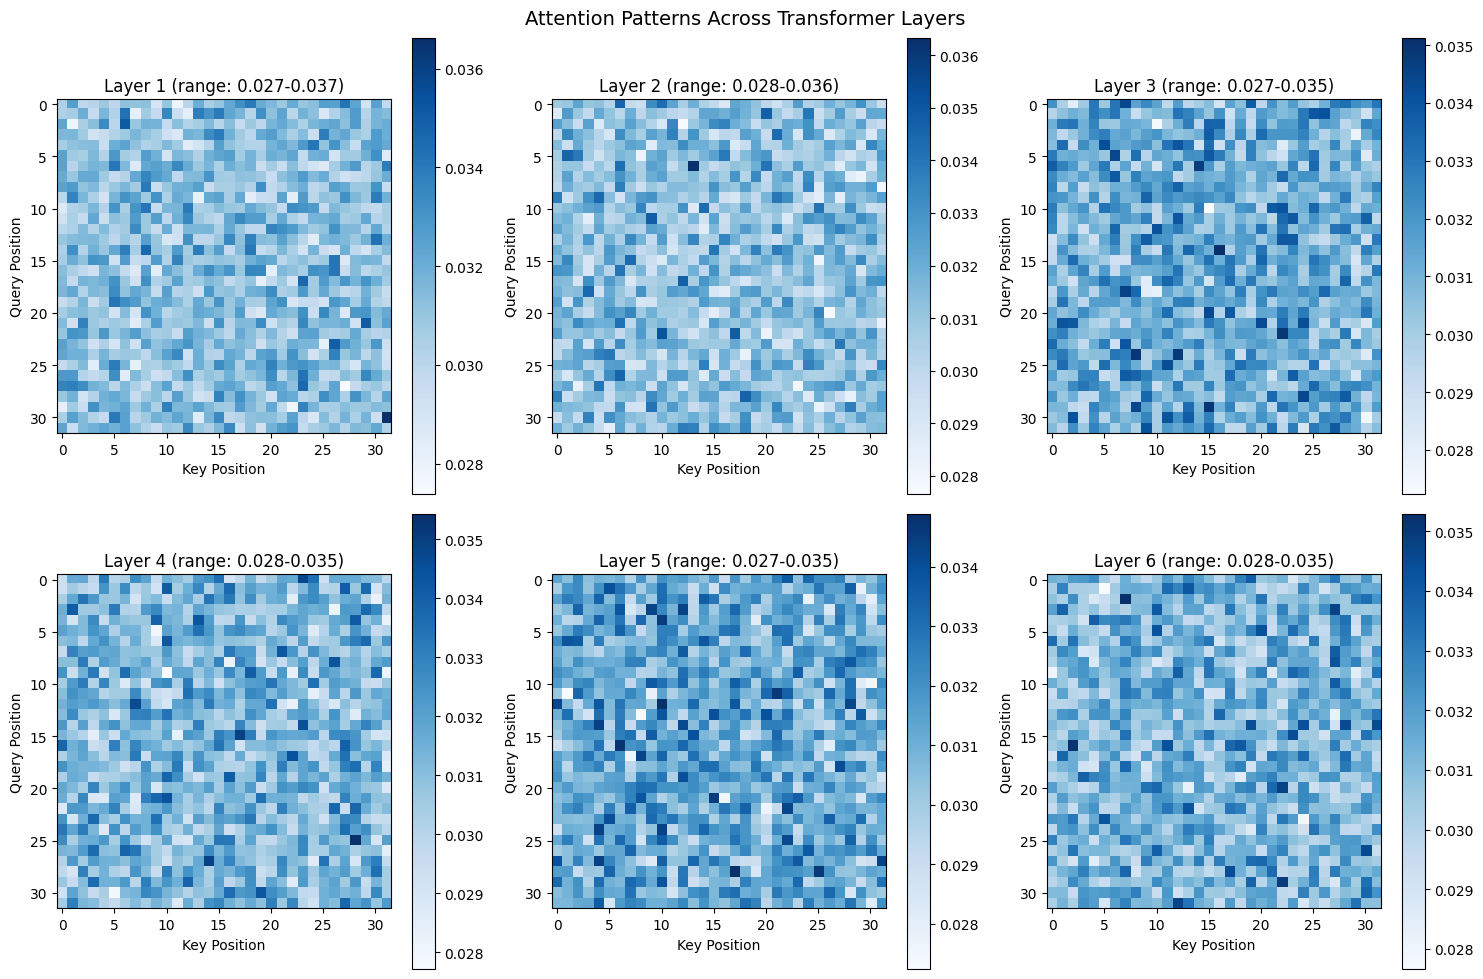

Different layers learn different attention patterns!

Note: With random untrained data, attention patterns are nearly uniform.
In trained models, you'd see much more distinct patterns (e.g., attending to specific positions).


In [9]:
# Visualize how attention patterns change across layers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for layer_idx in range(min(6, num_layers)):
    ax = axes[layer_idx]
    
    # Average attention across heads and batch
    avg_attn = attention_weights_per_layer[layer_idx].mean(dim=(0, 1)).detach().numpy()
    
    # Use adaptive color scale for better visibility
    vmin = avg_attn.min()
    vmax = avg_attn.max()
    
    im = ax.imshow(avg_attn, cmap='Blues', vmin=vmin, vmax=vmax)
    ax.set_title(f'Layer {layer_idx + 1} (range: {vmin:.3f}-{vmax:.3f})')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    plt.colorbar(im, ax=ax)

plt.suptitle('Attention Patterns Across Transformer Layers', fontsize=14)
plt.tight_layout()
plt.show()

print("Different layers learn different attention patterns!")
print("\nNote: With random untrained data, attention patterns are nearly uniform.")
print("In trained models, you'd see much more distinct patterns (e.g., attending to specific positions).")

## Part 6: Causal Masking Through Blocks

For autoregressive language modeling, we need to prevent positions from attending to future positions using a causal mask.

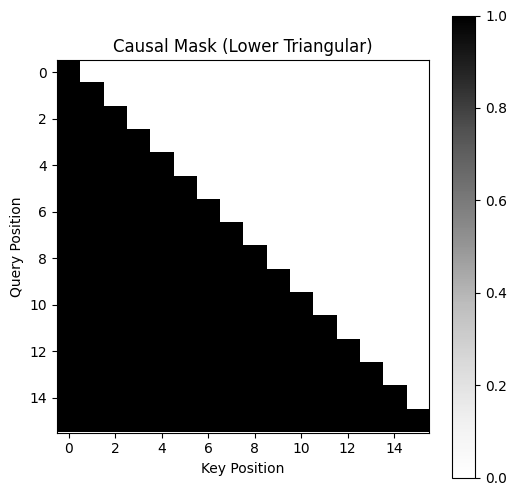

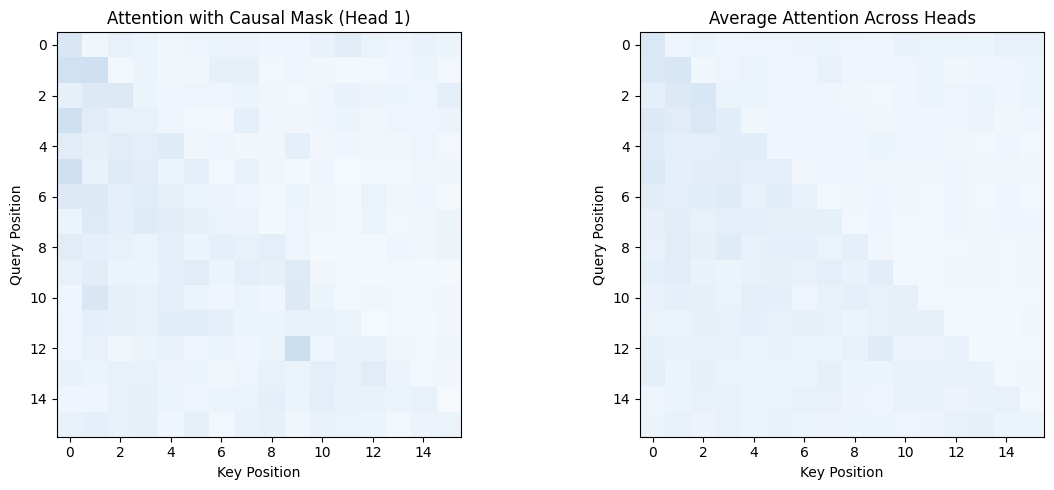

Causal mask successfully prevents attending to future positions!


In [10]:
# Create causal mask
seq_len = 16
causal_mask = torch.tril(torch.ones(seq_len, seq_len))

# Visualize mask
plt.figure(figsize=(6, 6))
plt.imshow(causal_mask.numpy(), cmap='Greys', vmin=0, vmax=1)
plt.title('Causal Mask (Lower Triangular)')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.colorbar()
plt.show()

# Test with mask
block = TransformerBlock(d_model=128, n_heads=4, d_ff=512, dropout=0.0)
block.eval()

x = torch.randn(1, seq_len, 128)
output, attn = block(x, mask=causal_mask, return_attention=True)

# Visualize masked attention
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Show first head
axes[0].imshow(attn[0, 0].detach().numpy(), cmap='Blues', vmin=0, vmax=1)
axes[0].set_title('Attention with Causal Mask (Head 1)')
axes[0].set_xlabel('Key Position')
axes[0].set_ylabel('Query Position')

# Show average across heads
avg_attn = attn[0].mean(dim=0).detach().numpy()
axes[1].imshow(avg_attn, cmap='Blues', vmin=0, vmax=1)
axes[1].set_title('Average Attention Across Heads')
axes[1].set_xlabel('Key Position')
axes[1].set_ylabel('Query Position')

plt.tight_layout()
plt.show()

print("Causal mask successfully prevents attending to future positions!")

## Part 7: Parameter Distribution Analysis

Let's analyze where parameters are distributed in a transformer block.

Parameter Distribution:
--------------------------------------------------
Self-Attention      :  1,050,624 ( 33.3%)
Feed-Forward        :  2,099,712 ( 66.6%)
LayerNorm           :      2,048 (  0.1%)
--------------------------------------------------
Total               :  3,152,384 (100.0%)


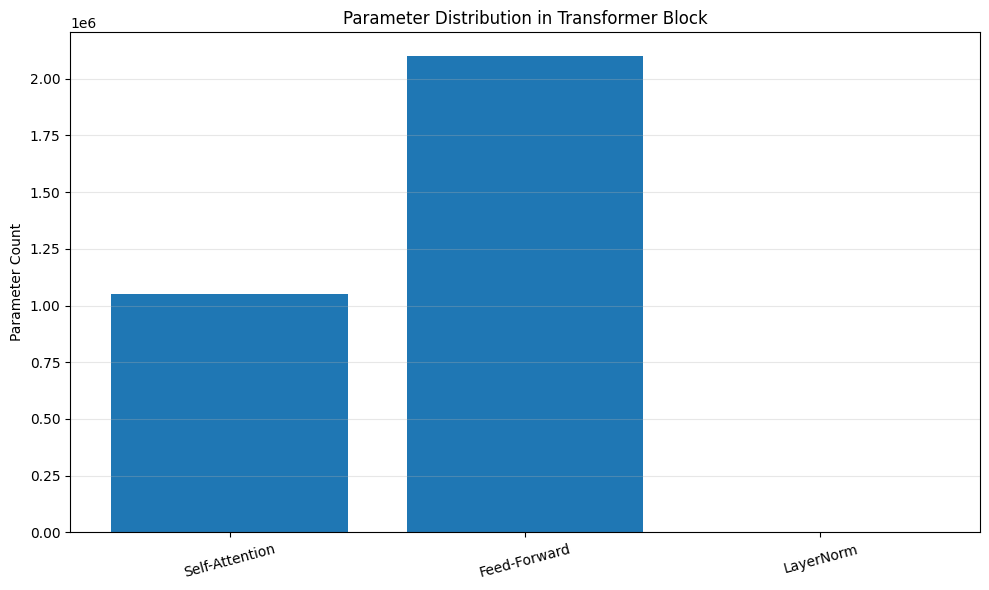

In [11]:
# Count parameters by component
block = TransformerBlock(d_model=512, n_heads=8, d_ff=2048)

param_counts = {
    'Self-Attention': sum(p.numel() for p in block.self_attn.parameters()),
    'Feed-Forward': sum(p.numel() for p in block.feed_forward.parameters()),
    'LayerNorm': sum(p.numel() for p in block.norm1.parameters()) + 
                 sum(p.numel() for p in block.norm2.parameters())
}

total_params = sum(param_counts.values())

print("Parameter Distribution:")
print("-" * 50)
for name, count in param_counts.items():
    percentage = (count / total_params) * 100
    print(f"{name:20s}: {count:>10,} ({percentage:>5.1f}%)")
print("-" * 50)
print(f"{'Total':20s}: {total_params:>10,} (100.0%)")

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(param_counts.keys(), param_counts.values())
plt.ylabel('Parameter Count')
plt.title('Parameter Distribution in Transformer Block')
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Summary

In this notebook, you've explored:

1. ✅ **Feed-Forward Networks** - Position-wise transformations
2. ✅ **Complete Transformer Block** - Integration of all components
3. ✅ **Residual Connections** - Gradient flow in deep networks
4. ✅ **Pre-LN Architecture** - Training stability
5. ✅ **Stacked Blocks** - Building deep transformers
6. ✅ **Causal Masking** - Autoregressive modeling
7. ✅ **Parameter Analysis** - Understanding model size

**Next Steps:**
- Complete the exercises in `exercises.py`
- Read the theory document for deeper mathematical understanding
- Move to Module 04: Embeddings & Positional Encoding